In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding

2024-04-09 20:19:27.643727: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 20:19:27.643875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 20:19:27.765169: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
model_checkpoint = 'cointegrated/rubert-tiny-sentiment-balanced'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
if torch.cuda.is_available():
    model.cuda()
    
def get_sentiment(text, return_type='label'):
    """ Calculate sentiment of a text. `return_type` can be 'label', 'score' or 'proba' """
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
        proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()[0]
    if return_type == 'label':
        return model.config.id2label[proba.argmax()]
    elif return_type == 'score':
        return proba.dot([-1, 0, 1])
    return proba

text = 'Какая гадость эта ваша заливная рыба!'
# classify the text
print(get_sentiment(text, 'label'))  # negative
# score the text on the scale from -1 (very negative) to +1 (very positive)
print(get_sentiment(text, 'score'))  # -0.5894946306943893
# calculate probabilities of all labels
print(get_sentiment(text, 'proba'))  # [0.7870447  0.4947824  0.19755007]

tokenizer_config.json:   0%|          | 0.00/377 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/884 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.2M [00:00<?, ?B/s]

negative
-0.589494600892067
[0.7870447 0.4947824 0.1975501]


In [5]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, e

In [6]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

In [7]:
full_sentiment_data = pd.read_csv('/kaggle/input/stock-news-sentiment/dataset_209_samples.csv')[['text', 'sentiment']]
full_sentiment_data

,text,sentiment
0,#AFKS #Отчетность\n🖨 АФК Система: МСФО 2023\n\...,Positive
1,#ENPG #Идея\n🧠 **Мозговой центр Сигналов РЦБ з...,Neutral
2,#MGNT\n**Магнит в моменте достиг 8000 рублей —...,Positive
3,#Политика\n🇷🇺 Запрет взыскания и ареста денег/...,Neutral
4,#GLTR\n⚡️ **Британский инвестфонд Southey Capi...,Neutral
...,...,...
204,- ТНС энерго Марий Эл - СД решит по дивидендам...,Neutral
205,02 апреля 2024 г - ТНС энерго НН - СД решит по...,Neutral
206,МНЕНИЕ: Дивиденд Астра за 2023 год составит не...,Positive
207,02.04.2024 г - КуйбышевАзот - СД решит по диви...,Neutral


In [8]:
train, test = train_test_split(full_sentiment_data, test_size=0.25, random_state=42)

<Axes: >

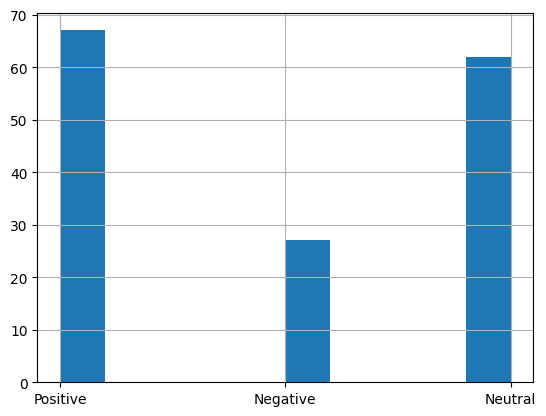

In [9]:
train.sentiment.hist()

<Axes: >

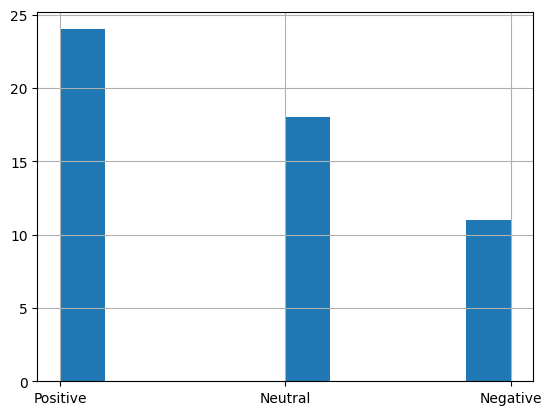

In [10]:
test.sentiment.hist()

In [11]:
torch_data = DatasetDict({
    'train': Dataset.from_pandas(train.reset_index(drop=True)),
    'test':   Dataset.from_pandas(test.reset_index(drop=True))
})
torch_data

DatasetDict({
    train: Dataset({
        features: ['text', 'sentiment'],
        num_rows: 156
    })
    test: Dataset({
        features: ['text', 'sentiment'],
        num_rows: 53
    })
})

In [12]:
all_labels = ['Negative', 'Neutral', 'Positive']

In [13]:
data_collator = DataCollatorWithPadding(tokenizer)

In [14]:
from torch.utils.data import DataLoader

In [15]:
data_tokenized = torch_data.map(
    lambda x: tokenizer(x["text"], truncation=True, padding=True), batched=True, remove_columns=['text']
)
data_tokenized = data_tokenized.map(lambda x: {'sentiment': [all_labels.index(xl) for xl in x['sentiment']]}, batched=True)


Map:   0%|          | 0/156 [00:00<?, ? examples/s]

Map:   0%|          | 0/53 [00:00<?, ? examples/s]

Map:   0%|          | 0/156 [00:00<?, ? examples/s]

Map:   0%|          | 0/53 [00:00<?, ? examples/s]

In [16]:
data_tokenized['test'].features

{'sentiment': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [17]:
batch_size = 8

train_dataloader = DataLoader(
    data_tokenized['train'], 
    batch_size=batch_size, drop_last=False, shuffle=True, num_workers=0, collate_fn=data_collator
)
test_dataloader = DataLoader(
    data_tokenized['test'], 
    batch_size=batch_size, drop_last=False, shuffle=True, num_workers=0, collate_fn=data_collator
)

In [18]:

from tqdm.auto import tqdm, trange
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from IPython.display import display
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dev_dataloader, verbose=False, labels=None):
    facts, preds = predict_with_model(model, dev_dataloader)
    pfrs, aucs = get_classification_report(facts, preds, labels)
    if verbose:
        display(pfrs)
        print('aucs:', aucs, np.mean(aucs))
    return np.mean(aucs)

def predict_with_model(model, dataloader):
    preds = []
    facts = []

    for batch in tqdm(dataloader):
        facts.append(batch.sentiment.cpu().numpy())
        batch = batch.to(model.device)
        with torch.no_grad():
            pr = model(input_ids=batch.input_ids, attention_mask=batch.attention_mask, token_type_ids=batch.token_type_ids)
        preds.append(torch.softmax(pr.logits, -1).cpu().numpy())
    facts = np.concatenate(facts)
    preds = np.concatenate(preds)
    return facts, preds

def get_classification_report(facts, preds, labels=None):
    pfrs = pd.DataFrame(dict(zip(['p', 'r', 'f', 's'], precision_recall_fscore_support(facts, preds.argmax(1)))))
    aucs = [roc_auc_score(facts==i, preds[:, i]) for i in set(facts)]
    pfrs['a'] = aucs
    pfrs = pd.concat([pfrs, pfrs.mean().to_frame().T], ignore_index=True)
    if labels is not None:
        pfrs.index = list(labels) + ['mean']
    return pfrs, aucs

def evaluate_model_matrix(model, dev_dataloader, verbose=False, labels=[0, 1, 2]):
    facts, preds = predict_with_model(model, dev_dataloader)
    pfrs, aucs = get_classification_report(facts, preds, labels)
    
    # Вычисление confusion matrix для каждого класса
    conf_matrices = {}
    for i, label in enumerate(labels):
        conf_matrices[label] = confusion_matrix(facts, preds.argmax(1), labels=[i])
        if verbose:
            plt.figure(figsize=(6, 4))
            sns.heatmap(conf_matrices[label], annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted labels')
            plt.ylabel('True labels')
            plt.title(f'Confusion Matrix for class {label}')
            plt.show()
    
    if verbose:
        display(pfrs)
        print('aucs:', aucs, np.mean(aucs))
    
    return np.mean(aucs), conf_matrices

In [19]:
evaluate_model(model, test_dataloader, verbose=True)

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.000000,0.000000,0.000000,11.000000,0.476190
1,0.395349,0.944444,0.557377,18.000000,0.496825
2,0.750000,0.250000,0.375000,24.000000,0.525862
3,0.381783,0.398148,0.310792,17.666667,0.499626


aucs: [0.47619047619047616, 0.49682539682539684, 0.5258620689655172] 0.49962598066046343


0.49962598066046343

In [34]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
if torch.cuda.is_available():
    model.cuda()

for name, param in model.named_parameters():
    if name.startswith('classifier') or 'bert.encoder.layer.2' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [21]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, e

In [22]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [23]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
gradient_accumulation_steps = 1
window = 500
cleanup_step = 100
report_step = 10000
ewm_loss = 0

In [25]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [26]:
import wandb

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [29]:
import torch.nn as nn

In [66]:
wandb.init(project="gagarin-hack-sentiment-bert", name="lr_1e-3_gamma_0.99_step_size_1_30_epochs")

best_val_auc = float(0)

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
if torch.cuda.is_available():
    model.cuda()

for name, param in model.named_parameters():
    if name.startswith('classifier') or 'bert.encoder.layer.2' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)  # Примерный шаг обучения каждые 3 эпохи, уменьшая lr на 0.9
criterion = nn.CrossEntropyLoss()

# Цикл обучения
# Создайте списки для сохранения предсказаний и целевых меток
all_preds = []
all_labels = []

best_model = model

# Цикл обучения
for epoch in trange(30):
    tq = tqdm(train_dataloader)
    
    for i, batch in enumerate(tq):
        try:
            batch = batch.to(model.device)
            output = model(batch.input_ids)
            logits = output.logits  # Получаем оценки вероятностей классов
            labels = batch.sentiment  # Получаем целевые метки
            loss = criterion(logits, labels)  # Вычисляем CrossEntropyLoss
            loss.backward()
        except RuntimeError as e:
            print('error on step', i, e)
            loss = None
            cleanup()
            continue

        if i and i % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            
        if i % cleanup_step == 0:
            cleanup()

        w = 1 / min(i+1, window)
        ewm_loss = ewm_loss * (1-w) + loss.item() * w
        tq.set_description(f'loss: {ewm_loss:4.4f}')
        
        if i % report_step == 0:
            model.eval()
            eval_loss = evaluate_model(model, test_dataloader, verbose=True)
            model.train()
            print(f'epoch {epoch}, step {i}: train loss: {ewm_loss:4.4f}  val auc: {eval_loss}')
            
            # Логируем метрики в wandb
            wandb.log({"train_loss": ewm_loss, "val_auc": eval_loss})

    # Шаг планировщика после каждой эпохи
    scheduler.step()
    
    model.eval()
    eval_loss = evaluate_model(model, test_dataloader, verbose=True)
    model.train()
    print(f'epoch {epoch + 1}, step {i}: train loss: {ewm_loss:4.4f}  val auc: {eval_loss}')
    
    if eval_loss > best_val_auc:
        best_val_auc = eval_loss
        torch.save(model, 'best_model.pth')


train_loss,█▃▂▃▁▁▁▂▁▃▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁
val_auc,▁▃▅█▇▇▇▆█▆███▆▇▇▆▅▅▆▃▃▄▄▄▆▅▆▅█
train_loss,0.00905
val_auc,0.72282


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.000000,0.000000,0.000000,11.000000,0.476190
1,0.395349,0.944444,0.557377,18.000000,0.496825
2,0.750000,0.250000,0.375000,24.000000,0.525862
3,0.381783,0.398148,0.310792,17.666667,0.499626


aucs: [0.47619047619047616, 0.49682539682539684, 0.5258620689655172] 0.49962598066046343
epoch 0, step 0: train loss: 3.3370  val auc: 0.49962598066046343


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,p,r,f,s,a
0,0.000000,0.000000,0.000000,11.000000,0.465368
1,0.454545,0.277778,0.344828,18.000000,0.582540
2,0.523810,0.916667,0.666667,24.000000,0.619253
3,0.326118,0.398148,0.337165,17.666667,0.555720


aucs: [0.4653679653679654, 0.5825396825396825, 0.6192528735632183] 0.555720173823622
epoch 1, step 19: train loss: 1.5834  val auc: 0.555720173823622


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,p,r,f,s,a
0,0.000000,0.000000,0.000000,11.000000,0.465368
1,0.454545,0.277778,0.344828,18.000000,0.582540
2,0.523810,0.916667,0.666667,24.000000,0.619253
3,0.326118,0.398148,0.337165,17.666667,0.555720


aucs: [0.4653679653679654, 0.5825396825396825, 0.6192528735632183] 0.555720173823622
epoch 1, step 0: train loss: 0.9913  val auc: 0.555720173823622


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.500000,0.181818,0.266667,11.000000,0.519481
1,0.361111,0.722222,0.481481,18.000000,0.561905
2,0.615385,0.333333,0.432432,24.000000,0.715517
3,0.492165,0.412458,0.393527,17.666667,0.598968


aucs: [0.5194805194805194, 0.5619047619047619, 0.7155172413793104] 0.5989675075881973
epoch 2, step 19: train loss: 1.0306  val auc: 0.5989675075881973


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.500000,0.181818,0.266667,11.000000,0.519481
1,0.361111,0.722222,0.481481,18.000000,0.561905
2,0.615385,0.333333,0.432432,24.000000,0.715517
3,0.492165,0.412458,0.393527,17.666667,0.598968


aucs: [0.5194805194805194, 0.5619047619047619, 0.7155172413793104] 0.5989675075881973
epoch 2, step 0: train loss: 1.0900  val auc: 0.5989675075881973


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.750000,0.272727,0.400000,11.000000,0.571429
1,0.361111,0.722222,0.481481,18.000000,0.604762
2,0.615385,0.333333,0.432432,24.000000,0.737069
3,0.575499,0.442761,0.437971,17.666667,0.637753


aucs: [0.5714285714285714, 0.6047619047619047, 0.7370689655172414] 0.6377531472359058
epoch 3, step 19: train loss: 0.8285  val auc: 0.6377531472359058


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.750000,0.272727,0.400000,11.000000,0.571429
1,0.361111,0.722222,0.481481,18.000000,0.604762
2,0.615385,0.333333,0.432432,24.000000,0.737069
3,0.575499,0.442761,0.437971,17.666667,0.637753


aucs: [0.5714285714285714, 0.6047619047619047, 0.7370689655172414] 0.6377531472359058
epoch 3, step 0: train loss: 0.6005  val auc: 0.6377531472359058


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.600000,0.272727,0.375000,11.000000,0.632035
1,0.444444,0.666667,0.533333,18.000000,0.661905
2,0.714286,0.625000,0.666667,24.000000,0.762931
3,0.586243,0.521465,0.525000,17.666667,0.685623


aucs: [0.632034632034632, 0.6619047619047619, 0.7629310344827587] 0.6856234761407176
epoch 4, step 19: train loss: 0.5533  val auc: 0.6856234761407176


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.600000,0.272727,0.375000,11.000000,0.632035
1,0.444444,0.666667,0.533333,18.000000,0.661905
2,0.714286,0.625000,0.666667,24.000000,0.762931
3,0.586243,0.521465,0.525000,17.666667,0.685623


aucs: [0.632034632034632, 0.6619047619047619, 0.7629310344827587] 0.6856234761407176
epoch 4, step 0: train loss: 0.1130  val auc: 0.6856234761407176


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.666667,0.181818,0.285714,11.000000,0.660173
1,0.419355,0.722222,0.530612,18.000000,0.646032
2,0.684211,0.541667,0.604651,24.000000,0.744253
3,0.590077,0.481902,0.473659,17.666667,0.683486


aucs: [0.6601731601731601, 0.6460317460317461, 0.7442528735632185] 0.6834859265893748
epoch 5, step 19: train loss: 0.4001  val auc: 0.6834859265893748


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.666667,0.181818,0.285714,11.000000,0.660173
1,0.419355,0.722222,0.530612,18.000000,0.646032
2,0.684211,0.541667,0.604651,24.000000,0.744253
3,0.590077,0.481902,0.473659,17.666667,0.683486


aucs: [0.6601731601731601, 0.6460317460317461, 0.7442528735632185] 0.6834859265893748
epoch 5, step 0: train loss: 0.4432  val auc: 0.6834859265893748


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.500000,0.363636,0.421053,11.000000,0.608225
1,0.440000,0.611111,0.511628,18.000000,0.665079
2,0.700000,0.583333,0.636364,24.000000,0.780172
3,0.546667,0.519360,0.523015,17.666667,0.684492


aucs: [0.6082251082251082, 0.6650793650793652, 0.7801724137931034] 0.6844922956991922
epoch 6, step 19: train loss: 0.2675  val auc: 0.6844922956991922


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.500000,0.363636,0.421053,11.000000,0.608225
1,0.440000,0.611111,0.511628,18.000000,0.665079
2,0.700000,0.583333,0.636364,24.000000,0.780172
3,0.546667,0.519360,0.523015,17.666667,0.684492


aucs: [0.6082251082251082, 0.6650793650793652, 0.7801724137931034] 0.6844922956991922
epoch 6, step 0: train loss: 0.0687  val auc: 0.6844922956991922


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.750000,0.272727,0.400000,11.000000,0.686147
1,0.413793,0.666667,0.510638,18.000000,0.671429
2,0.700000,0.583333,0.636364,24.000000,0.788793
3,0.621264,0.507576,0.515667,17.666667,0.715456


aucs: [0.6861471861471862, 0.6714285714285715, 0.7887931034482758] 0.7154562870080111
epoch 7, step 19: train loss: 0.2555  val auc: 0.7154562870080111


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.750000,0.272727,0.400000,11.000000,0.686147
1,0.413793,0.666667,0.510638,18.000000,0.671429
2,0.700000,0.583333,0.636364,24.000000,0.788793
3,0.621264,0.507576,0.515667,17.666667,0.715456


aucs: [0.6861471861471862, 0.6714285714285715, 0.7887931034482758] 0.7154562870080111
epoch 7, step 0: train loss: 0.1080  val auc: 0.7154562870080111


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,1.000000,0.454545,0.625000,11.000000,0.725108
1,0.440000,0.611111,0.511628,18.000000,0.706349
2,0.695652,0.666667,0.680851,24.000000,0.818966
3,0.711884,0.577441,0.605826,17.666667,0.750141


aucs: [0.7251082251082251, 0.7063492063492064, 0.8189655172413792] 0.7501409828996035
epoch 8, step 19: train loss: 0.2292  val auc: 0.7501409828996035


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,1.000000,0.454545,0.625000,11.000000,0.725108
1,0.440000,0.611111,0.511628,18.000000,0.706349
2,0.695652,0.666667,0.680851,24.000000,0.818966
3,0.711884,0.577441,0.605826,17.666667,0.750141


aucs: [0.7251082251082251, 0.7063492063492064, 0.8189655172413792] 0.7501409828996035
epoch 8, step 0: train loss: 0.2787  val auc: 0.7501409828996035


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.800000,0.363636,0.500000,11.000000,0.725108
1,0.366667,0.611111,0.458333,18.000000,0.676190
2,0.666667,0.500000,0.571429,24.000000,0.785920
3,0.611111,0.491582,0.509921,17.666667,0.729073


aucs: [0.725108225108225, 0.6761904761904762, 0.7859195402298851] 0.7290727471761954
epoch 9, step 19: train loss: 0.1221  val auc: 0.7290727471761954


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.800000,0.363636,0.500000,11.000000,0.725108
1,0.366667,0.611111,0.458333,18.000000,0.676190
2,0.666667,0.500000,0.571429,24.000000,0.785920
3,0.611111,0.491582,0.509921,17.666667,0.729073


aucs: [0.725108225108225, 0.6761904761904762, 0.7859195402298851] 0.7290727471761954
epoch 9, step 0: train loss: 0.0797  val auc: 0.7290727471761954


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.428571,0.272727,0.333333,11.000000,0.751082
1,0.434783,0.555556,0.487805,18.000000,0.653968
2,0.652174,0.625000,0.638298,24.000000,0.770115
3,0.505176,0.484428,0.486479,17.666667,0.725055


aucs: [0.7510822510822511, 0.6539682539682541, 0.7701149425287356] 0.7250551491930802
epoch 10, step 19: train loss: 0.0965  val auc: 0.7250551491930802


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.428571,0.272727,0.333333,11.000000,0.751082
1,0.434783,0.555556,0.487805,18.000000,0.653968
2,0.652174,0.625000,0.638298,24.000000,0.770115
3,0.505176,0.484428,0.486479,17.666667,0.725055


aucs: [0.7510822510822511, 0.6539682539682541, 0.7701149425287356] 0.7250551491930802
epoch 10, step 0: train loss: 0.0214  val auc: 0.7250551491930802


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.555556,0.454545,0.500000,11.000000,0.727273
1,0.400000,0.555556,0.465116,18.000000,0.666667
2,0.631579,0.500000,0.558140,24.000000,0.791667
3,0.529045,0.503367,0.507752,17.666667,0.728535


aucs: [0.7272727272727273, 0.6666666666666667, 0.7916666666666666] 0.7285353535353535
epoch 11, step 19: train loss: 0.1604  val auc: 0.7285353535353535


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.555556,0.454545,0.500000,11.000000,0.727273
1,0.400000,0.555556,0.465116,18.000000,0.666667
2,0.631579,0.500000,0.558140,24.000000,0.791667
3,0.529045,0.503367,0.507752,17.666667,0.728535


aucs: [0.7272727272727273, 0.6666666666666667, 0.7916666666666666] 0.7285353535353535
epoch 11, step 0: train loss: 0.0137  val auc: 0.7285353535353535


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.000000,0.000000,0.000000,11.000000,0.699134
1,0.642857,0.500000,0.562500,18.000000,0.738095
2,0.638889,0.958333,0.766667,24.000000,0.823276
3,0.427249,0.486111,0.443056,17.666667,0.753502


aucs: [0.6991341991341992, 0.7380952380952381, 0.8232758620689655] 0.7535017664328011
epoch 12, step 19: train loss: 0.2699  val auc: 0.7535017664328011


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.000000,0.000000,0.000000,11.000000,0.699134
1,0.642857,0.500000,0.562500,18.000000,0.738095
2,0.638889,0.958333,0.766667,24.000000,0.823276
3,0.427249,0.486111,0.443056,17.666667,0.753502


aucs: [0.6991341991341992, 0.7380952380952381, 0.8232758620689655] 0.7535017664328011
epoch 12, step 0: train loss: 0.2708  val auc: 0.7535017664328011


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.500000,0.090909,0.153846,11.000000,0.731602
1,0.411765,0.777778,0.538462,18.000000,0.671429
2,0.647059,0.458333,0.536585,24.000000,0.706897
3,0.519608,0.442340,0.409631,17.666667,0.703309


aucs: [0.7316017316017316, 0.6714285714285715, 0.7068965517241379] 0.7033089515848138
epoch 13, step 19: train loss: 0.3827  val auc: 0.7033089515848138


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.500000,0.090909,0.153846,11.000000,0.731602
1,0.411765,0.777778,0.538462,18.000000,0.671429
2,0.647059,0.458333,0.536585,24.000000,0.706897
3,0.519608,0.442340,0.409631,17.666667,0.703309


aucs: [0.7316017316017316, 0.6714285714285715, 0.7068965517241379] 0.7033089515848138
epoch 13, step 0: train loss: 0.2673  val auc: 0.7033089515848138


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.500000,0.272727,0.352941,11.000000,0.694805
1,0.424242,0.777778,0.549020,18.000000,0.707937
2,0.714286,0.416667,0.526316,24.000000,0.777299
3,0.546176,0.489057,0.476092,17.666667,0.726680


aucs: [0.6948051948051948, 0.7079365079365081, 0.7772988505747126] 0.7266801844388051
epoch 14, step 19: train loss: 0.2300  val auc: 0.7266801844388051


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.500000,0.272727,0.352941,11.000000,0.694805
1,0.424242,0.777778,0.549020,18.000000,0.707937
2,0.714286,0.416667,0.526316,24.000000,0.777299
3,0.546176,0.489057,0.476092,17.666667,0.726680


aucs: [0.6948051948051948, 0.7079365079365081, 0.7772988505747126] 0.7266801844388051
epoch 14, step 0: train loss: 0.3660  val auc: 0.7266801844388051


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.500000,0.090909,0.153846,11.000000,0.720779
1,0.500000,0.722222,0.590909,18.000000,0.711111
2,0.640000,0.666667,0.653061,24.000000,0.772989
3,0.546667,0.493266,0.465939,17.666667,0.734960


aucs: [0.7207792207792207, 0.711111111111111, 0.7729885057471264] 0.7349596125458193
epoch 15, step 19: train loss: 0.1650  val auc: 0.7349596125458193


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.500000,0.090909,0.153846,11.000000,0.720779
1,0.500000,0.722222,0.590909,18.000000,0.711111
2,0.640000,0.666667,0.653061,24.000000,0.772989
3,0.546667,0.493266,0.465939,17.666667,0.734960


aucs: [0.7207792207792207, 0.711111111111111, 0.7729885057471264] 0.7349596125458193
epoch 15, step 0: train loss: 0.3525  val auc: 0.7349596125458193


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.714286,0.454545,0.555556,11.000000,0.679654
1,0.481481,0.722222,0.577778,18.000000,0.715873
2,0.789474,0.625000,0.697674,24.000000,0.833333
3,0.661747,0.600589,0.610336,17.666667,0.742953


aucs: [0.6796536796536796, 0.7158730158730159, 0.8333333333333333] 0.742953342953343
epoch 16, step 19: train loss: 0.1073  val auc: 0.742953342953343


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.714286,0.454545,0.555556,11.000000,0.679654
1,0.481481,0.722222,0.577778,18.000000,0.715873
2,0.789474,0.625000,0.697674,24.000000,0.833333
3,0.661747,0.600589,0.610336,17.666667,0.742953


aucs: [0.6796536796536796, 0.7158730158730159, 0.8333333333333333] 0.742953342953343
epoch 16, step 0: train loss: 0.0294  val auc: 0.742953342953343


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.714286,0.454545,0.555556,11.000000,0.751082
1,0.500000,0.722222,0.590909,18.000000,0.711111
2,0.800000,0.666667,0.727273,24.000000,0.807471
3,0.671429,0.614478,0.624579,17.666667,0.756555


aucs: [0.751082251082251, 0.7111111111111111, 0.8074712643678161] 0.7565548755203927
epoch 17, step 19: train loss: 0.0276  val auc: 0.7565548755203927


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.714286,0.454545,0.555556,11.000000,0.751082
1,0.500000,0.722222,0.590909,18.000000,0.711111
2,0.800000,0.666667,0.727273,24.000000,0.807471
3,0.671429,0.614478,0.624579,17.666667,0.756555


aucs: [0.751082251082251, 0.7111111111111111, 0.8074712643678161] 0.7565548755203927
epoch 17, step 0: train loss: 0.0613  val auc: 0.7565548755203927


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.600000,0.272727,0.375000,11.000000,0.772727
1,0.464286,0.722222,0.565217,18.000000,0.701587
2,0.800000,0.666667,0.727273,24.000000,0.800287
3,0.621429,0.553872,0.555830,17.666667,0.758201


aucs: [0.7727272727272727, 0.7015873015873016, 0.8002873563218391] 0.7582006435454711
epoch 18, step 19: train loss: 0.0181  val auc: 0.7582006435454711


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.600000,0.272727,0.375000,11.000000,0.772727
1,0.464286,0.722222,0.565217,18.000000,0.701587
2,0.800000,0.666667,0.727273,24.000000,0.800287
3,0.621429,0.553872,0.555830,17.666667,0.758201


aucs: [0.7727272727272727, 0.7015873015873016, 0.8002873563218391] 0.7582006435454711
epoch 18, step 0: train loss: 0.0018  val auc: 0.7582006435454711


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.600000,0.272727,0.375000,11.000000,0.757576
1,0.451613,0.777778,0.571429,18.000000,0.738095
2,0.823529,0.583333,0.682927,24.000000,0.804598
3,0.625047,0.544613,0.543118,17.666667,0.766756


aucs: [0.7575757575757576, 0.7380952380952382, 0.8045977011494253] 0.7667562322734738
epoch 19, step 19: train loss: 0.0204  val auc: 0.7667562322734738


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.600000,0.272727,0.375000,11.000000,0.757576
1,0.451613,0.777778,0.571429,18.000000,0.738095
2,0.823529,0.583333,0.682927,24.000000,0.804598
3,0.625047,0.544613,0.543118,17.666667,0.766756


aucs: [0.7575757575757576, 0.7380952380952382, 0.8045977011494253] 0.7667562322734738
epoch 19, step 0: train loss: 0.0189  val auc: 0.7667562322734738


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.500000,0.181818,0.266667,11.000000,0.785714
1,0.428571,0.666667,0.521739,18.000000,0.692063
2,0.714286,0.625000,0.666667,24.000000,0.772989
3,0.547619,0.491162,0.485024,17.666667,0.750255


aucs: [0.7857142857142857, 0.692063492063492, 0.7729885057471264] 0.7502554278416348
epoch 20, step 19: train loss: 0.0259  val auc: 0.7502554278416348


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.500000,0.181818,0.266667,11.000000,0.785714
1,0.428571,0.666667,0.521739,18.000000,0.692063
2,0.714286,0.625000,0.666667,24.000000,0.772989
3,0.547619,0.491162,0.485024,17.666667,0.750255


aucs: [0.7857142857142857, 0.692063492063492, 0.7729885057471264] 0.7502554278416348
epoch 20, step 0: train loss: 0.1371  val auc: 0.7502554278416348


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.666667,0.363636,0.470588,11.000000,0.740260
1,0.406250,0.722222,0.520000,18.000000,0.619048
2,0.733333,0.458333,0.564103,24.000000,0.712644
3,0.602083,0.514731,0.518230,17.666667,0.690650


aucs: [0.7402597402597403, 0.6190476190476191, 0.7126436781609196] 0.6906503458227595
epoch 21, step 19: train loss: 0.0942  val auc: 0.6906503458227595


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.666667,0.363636,0.470588,11.000000,0.740260
1,0.406250,0.722222,0.520000,18.000000,0.619048
2,0.733333,0.458333,0.564103,24.000000,0.712644
3,0.602083,0.514731,0.518230,17.666667,0.690650


aucs: [0.7402597402597403, 0.6190476190476191, 0.7126436781609196] 0.6906503458227595
epoch 21, step 0: train loss: 0.0120  val auc: 0.6906503458227595


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.600000,0.272727,0.375000,11.000000,0.735931
1,0.407407,0.611111,0.488889,18.000000,0.673016
2,0.619048,0.541667,0.577778,24.000000,0.777299
3,0.542152,0.475168,0.480556,17.666667,0.728748


aucs: [0.735930735930736, 0.6730158730158731, 0.7772988505747127] 0.7287484865071073
epoch 22, step 19: train loss: 0.2006  val auc: 0.7287484865071073


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.600000,0.272727,0.375000,11.000000,0.735931
1,0.407407,0.611111,0.488889,18.000000,0.673016
2,0.619048,0.541667,0.577778,24.000000,0.777299
3,0.542152,0.475168,0.480556,17.666667,0.728748


aucs: [0.735930735930736, 0.6730158730158731, 0.7772988505747127] 0.7287484865071073
epoch 22, step 0: train loss: 0.0121  val auc: 0.7287484865071073


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.625000,0.454545,0.526316,11.000000,0.668831
1,0.454545,0.555556,0.500000,18.000000,0.666667
2,0.652174,0.625000,0.638298,24.000000,0.795977
3,0.577240,0.545034,0.554871,17.666667,0.710492


aucs: [0.6688311688311689, 0.6666666666666666, 0.7959770114942528] 0.7104916156640294
epoch 23, step 19: train loss: 0.1125  val auc: 0.7104916156640294


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.625000,0.454545,0.526316,11.000000,0.668831
1,0.454545,0.555556,0.500000,18.000000,0.666667
2,0.652174,0.625000,0.638298,24.000000,0.795977
3,0.577240,0.545034,0.554871,17.666667,0.710492


aucs: [0.6688311688311689, 0.6666666666666666, 0.7959770114942528] 0.7104916156640294
epoch 23, step 0: train loss: 0.0610  val auc: 0.7104916156640294


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.600000,0.272727,0.375000,11.000000,0.727273
1,0.428571,0.833333,0.566038,18.000000,0.685714
2,0.846154,0.458333,0.594595,24.000000,0.688218
3,0.624908,0.521465,0.511877,17.666667,0.700402


aucs: [0.7272727272727273, 0.6857142857142857, 0.6882183908045978] 0.7004018012638703
epoch 24, step 19: train loss: 0.0627  val auc: 0.7004018012638703


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.600000,0.272727,0.375000,11.000000,0.727273
1,0.428571,0.833333,0.566038,18.000000,0.685714
2,0.846154,0.458333,0.594595,24.000000,0.688218
3,0.624908,0.521465,0.511877,17.666667,0.700402


aucs: [0.7272727272727273, 0.6857142857142857, 0.6882183908045978] 0.7004018012638703
epoch 24, step 0: train loss: 0.0044  val auc: 0.7004018012638703


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.714286,0.454545,0.555556,11.000000,0.809524
1,0.444444,0.666667,0.533333,18.000000,0.698413
2,0.684211,0.541667,0.604651,24.000000,0.712644
3,0.614314,0.554293,0.564513,17.666667,0.740193


aucs: [0.8095238095238095, 0.6984126984126984, 0.7126436781609194] 0.7401933953658091
epoch 25, step 19: train loss: 0.0501  val auc: 0.7401933953658091


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.714286,0.454545,0.555556,11.000000,0.809524
1,0.444444,0.666667,0.533333,18.000000,0.698413
2,0.684211,0.541667,0.604651,24.000000,0.712644
3,0.614314,0.554293,0.564513,17.666667,0.740193


aucs: [0.8095238095238095, 0.6984126984126984, 0.7126436781609194] 0.7401933953658091
epoch 25, step 0: train loss: 0.0504  val auc: 0.7401933953658091


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.625000,0.454545,0.526316,11.000000,0.794372
1,0.423077,0.611111,0.500000,18.000000,0.698413
2,0.684211,0.541667,0.604651,24.000000,0.714080
3,0.577429,0.535774,0.543656,17.666667,0.735622


aucs: [0.7943722943722944, 0.6984126984126985, 0.7140804597701149] 0.7356218175183692
epoch 26, step 19: train loss: 0.0203  val auc: 0.7356218175183692


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.625000,0.454545,0.526316,11.000000,0.794372
1,0.423077,0.611111,0.500000,18.000000,0.698413
2,0.684211,0.541667,0.604651,24.000000,0.714080
3,0.577429,0.535774,0.543656,17.666667,0.735622


aucs: [0.7943722943722944, 0.6984126984126985, 0.7140804597701149] 0.7356218175183692
epoch 26, step 0: train loss: 0.0728  val auc: 0.7356218175183692


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.625000,0.454545,0.526316,11.000000,0.653680
1,0.448276,0.722222,0.553191,18.000000,0.647619
2,0.750000,0.500000,0.600000,24.000000,0.681034
3,0.607759,0.558923,0.559836,17.666667,0.660778


aucs: [0.6536796536796537, 0.6476190476190476, 0.6810344827586207] 0.6607777280191073
epoch 27, step 19: train loss: 0.0513  val auc: 0.6607777280191073


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.625000,0.454545,0.526316,11.000000,0.653680
1,0.448276,0.722222,0.553191,18.000000,0.647619
2,0.750000,0.500000,0.600000,24.000000,0.681034
3,0.607759,0.558923,0.559836,17.666667,0.660778


aucs: [0.6536796536796537, 0.6476190476190476, 0.6810344827586207] 0.6607777280191073
epoch 27, step 0: train loss: 0.0060  val auc: 0.6607777280191073


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.500000,0.181818,0.266667,11.000000,0.716450
1,0.406250,0.722222,0.520000,18.000000,0.606349
2,0.705882,0.500000,0.585366,24.000000,0.639368
3,0.537377,0.468013,0.457344,17.666667,0.654056


aucs: [0.7164502164502164, 0.6063492063492063, 0.639367816091954] 0.6540557462971256
epoch 28, step 19: train loss: 0.0209  val auc: 0.6540557462971256


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.500000,0.181818,0.266667,11.000000,0.716450
1,0.406250,0.722222,0.520000,18.000000,0.606349
2,0.705882,0.500000,0.585366,24.000000,0.639368
3,0.537377,0.468013,0.457344,17.666667,0.654056


aucs: [0.7164502164502164, 0.6063492063492063, 0.639367816091954] 0.6540557462971256
epoch 28, step 0: train loss: 0.0208  val auc: 0.6540557462971256


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.625000,0.454545,0.526316,11.000000,0.699134
1,0.451613,0.777778,0.571429,18.000000,0.619048
2,0.785714,0.458333,0.578947,24.000000,0.633621
3,0.620776,0.563552,0.558897,17.666667,0.650601


aucs: [0.699134199134199, 0.6190476190476191, 0.6336206896551724] 0.6506008359456635
epoch 29, step 19: train loss: 0.0419  val auc: 0.6506008359456635


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.625000,0.454545,0.526316,11.000000,0.699134
1,0.451613,0.777778,0.571429,18.000000,0.619048
2,0.785714,0.458333,0.578947,24.000000,0.633621
3,0.620776,0.563552,0.558897,17.666667,0.650601


aucs: [0.699134199134199, 0.6190476190476191, 0.6336206896551724] 0.6506008359456635
epoch 29, step 0: train loss: 0.0016  val auc: 0.6506008359456635


  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.600000,0.272727,0.375000,11.000000,0.707792
1,0.419355,0.722222,0.530612,18.000000,0.631746
2,0.705882,0.500000,0.585366,24.000000,0.669540
3,0.575079,0.498316,0.496993,17.666667,0.669693


aucs: [0.7077922077922078, 0.6317460317460317, 0.6695402298850575] 0.6696928231410991
epoch 30, step 19: train loss: 0.0542  val auc: 0.6696928231410991


In [70]:
best_model = torch.load('best_model.pth')
best_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, e

  0%|          | 0/7 [00:00<?, ?it/s]

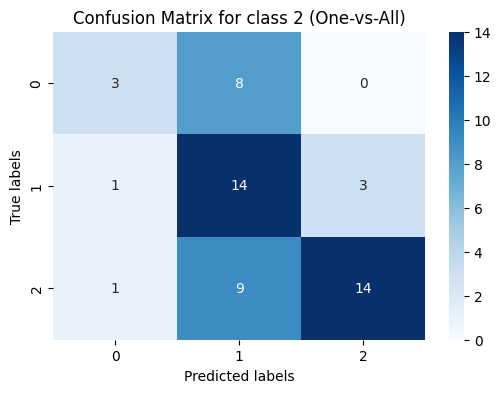

In [92]:
def one_vs_all_confusion_matrix(facts, preds, class_label):
    # Вычисляем метки класса "one-versus-all"
#     one_vs_all_labels = np.where(facts == class_label, 1, 0)
    
    # Вычисляем матрицу ошибок
    
    conf_matrix = confusion_matrix(facts, preds.argmax(1))
    
    return conf_matrix

facts, preds = predict_with_model(best_model, test_dataloader)
# Создаем словарь для хранения матриц ошибок "one-versus-all" для каждого класса
conf_matrices = {}


conf_matrices[label] = one_vs_all_confusion_matrix(facts, preds, label)

# Выводим матрицу ошибок "one-versus-all" для текущего класса
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrices[label], annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix for class {label} (One-vs-All)')
plt.show()

In [84]:
best_model.eval()
evaluate_model(best_model, test_dataloader, verbose=True)

  0%|          | 0/7 [00:00<?, ?it/s]

,p,r,f,s,a
0,0.600000,0.272727,0.375000,11.000000,0.757576
1,0.451613,0.777778,0.571429,18.000000,0.738095
2,0.823529,0.583333,0.682927,24.000000,0.804598
3,0.625047,0.544613,0.543118,17.666667,0.766756


aucs: [0.7575757575757576, 0.7380952380952382, 0.8045977011494253] 0.7667562322734738


0.7667562322734738